In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_small=pd.read_csv('/content/drive/MyDrive/DataSet/df_small.csv')

In [ ]:
!pip install torchtext==0.6.0
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [ ]:
import pandas as pd
import torch
from torch import nn, optim
from torchtext import data
from torchtext.vocab import GloVe
import html  # Import the html library for decoding HTML entities
import spacy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:


# Create a spaCy tokenizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

In [ ]:
# Define a custom tokenizer function to handle decoding and tokenization
def custom_tokenizer(text):
    decoded_text = html.unescape(text)
    tokens = [tok.text for tok in nlp(decoded_text)]
    return tokens

In [ ]:

# Define the text and label fields
TEXT = data.Field(
    sequential=True,
    tokenize=custom_tokenizer,
    lower=True,
    include_lengths=True,
    fix_length=100
)
LABEL = data.LabelField(dtype=torch.float)

# Create examples from your DataFrame
examples = [data.Example.fromlist([html.unescape(text), label], fields=[('text', TEXT), ('label', LABEL)]) for text, label in zip(df_small['text'], df_small['label'])]

# Create a Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Split the dataset
train_data, temp_data = dataset.split(split_ratio=0.8)
val_data, test_data = temp_data.split(split_ratio=0.5)

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=20000, vectors=GloVe(name="6B", dim=300, unk_init=torch.Tensor.normal_))
LABEL.build_vocab(train_data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
.vector_cache/glove.6B.zip: 862MB [08:25, 1.70MB/s]                           
100%|█████████▉| 399999/400000 [01:00<00:00, 6593.19it/s]


In [ ]:
# Create iterators for the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)

In [ ]:

# Define the LSTM-based text classification model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        text_lengths = text_lengths.cpu()  # Move the lengths tensor to the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :])
        return self.fc(hidden)

In [ ]:
vocab_size = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 256  # Increase hidden layer dimensions
output_dim = 1
n_layers = 3
bidirectional = True
dropout = 0.5

# Initialize the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adjust learning rate and weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Move the model to the appropriate device
model = model.to(device)

In [ ]:
# Training loop
def train_model(
    model,
    train_iter,
    val_iter,
    optimizer,
    scheduler,
    criterion=nn.BCEWithLogitsLoss(),
    epochs=10,
    early_stopping=False,
    patience=4,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    if early_stopping:
        patience_count = 0
        best_val_loss = float("inf")

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for batch in train_iter:
            optimizer.zero_grad()
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += binary_accuracy(predictions, labels)

        train_loss /= len(train_iter)
        train_acc /= len(train_iter)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_iter, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if early_stopping:
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping. Patience limit reached.")
                    break

    return train_losses, val_losses, train_accs, val_accs

In [ ]:

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:

# Train the model
train_model(
    model,
    train_iter,
    val_iter,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=15,  # Increase the number of epochs
    early_stopping=False,
    patience=4,
)

Epoch: 1, Train Loss: 0.6280, Train Acc: 0.6513, Val Loss: 0.5914, Val Acc: 0.7038
Epoch: 2, Train Loss: 0.5732, Train Acc: 0.7050, Val Loss: 0.5302, Val Acc: 0.7420
Epoch: 3, Train Loss: 0.5283, Train Acc: 0.7441, Val Loss: 0.5543, Val Acc: 0.7414
Epoch: 4, Train Loss: 0.5146, Train Acc: 0.7526, Val Loss: 0.4942, Val Acc: 0.7646
Epoch: 5, Train Loss: 0.5017, Train Acc: 0.7630, Val Loss: 0.4720, Val Acc: 0.7866
Epoch: 6, Train Loss: 0.4923, Train Acc: 0.7715, Val Loss: 0.4724, Val Acc: 0.7773
Epoch: 7, Train Loss: 0.4813, Train Acc: 0.7758, Val Loss: 0.4654, Val Acc: 0.7856
Epoch: 8, Train Loss: 0.4713, Train Acc: 0.7827, Val Loss: 0.4629, Val Acc: 0.7816
Epoch: 9, Train Loss: 0.4677, Train Acc: 0.7865, Val Loss: 0.4813, Val Acc: 0.7696
Epoch: 10, Train Loss: 0.4662, Train Acc: 0.7877, Val Loss: 0.4547, Val Acc: 0.7879
Epoch: 11, Train Loss: 0.4574, Train Acc: 0.7915, Val Loss: 0.4592, Val Acc: 0.7806
Epoch: 12, Train Loss: 0.4582, Train Acc: 0.7930, Val Loss: 0.4798, Val Acc: 0.7706
E

([0.6279521831870079,
  0.5731958141525586,
  0.5283221187790235,
  0.5145665989468495,
  0.501747361421585,
  0.4923386955956618,
  0.48126936973134676,
  0.4712705417176088,
  0.46768728784720104,
  0.466198259661595,
  0.4574256326854229,
  0.45818284067014853,
  0.4505148741503557,
  0.4491575150589148,
  0.4489408620248238],
 [0.5914368268023146,
  0.530166542593469,
  0.5543361643844462,
  0.4941731994139387,
  0.472010658855768,
  0.47238387349755206,
  0.4654441766757914,
  0.4629259359170782,
  0.48134967882899526,
  0.45471973534911236,
  0.45923406004588657,
  0.4797764433191178,
  0.4569515692902372,
  0.4702575507157661,
  0.4703775034781466],
 [tensor(0.6513, device='cuda:0'),
  tensor(0.7050, device='cuda:0'),
  tensor(0.7441, device='cuda:0'),
  tensor(0.7526, device='cuda:0'),
  tensor(0.7630, device='cuda:0'),
  tensor(0.7715, device='cuda:0'),
  tensor(0.7758, device='cuda:0'),
  tensor(0.7827, device='cuda:0'),
  tensor(0.7865, device='cuda:0'),
  tensor(0.7877, dev

In [ ]:
# Test the model
print("Test set results:")
test_loss, test_acc = evaluate_model(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test set results:
Test Loss: 0.4929, Test Acc: 0.7680


Test Loss: 0.4929, Test Accuracy: 0.7687, F1 Score: 0.7907
Confusion Matrix:
[[ 995  514]
 [ 180 1311]]


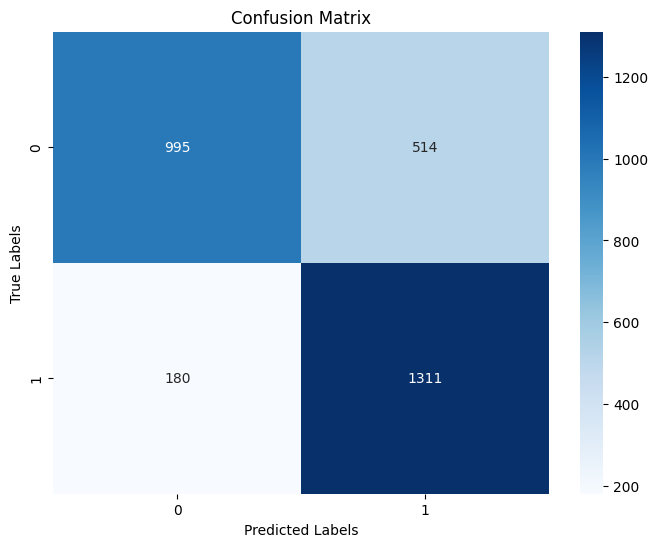

In [ ]:

# Define function to calculate F1 score and accuracy
def evaluate_test_set(model, test_iterator, criterion):
    model.eval()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            # Calculate F1 score
            rounded_preds = torch.round(torch.sigmoid(predictions))
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(rounded_preds.cpu().numpy())

    test_loss = epoch_loss / len(test_iterator)
    test_acc = binary_accuracy(torch.tensor(predicted_labels), torch.tensor(true_labels))

    f1 = f1_score(true_labels, predicted_labels)

    return test_loss, test_acc, f1, true_labels, predicted_labels

# Evaluate on the test set
test_loss, test_acc, f1, true_labels, predicted_labels = evaluate_test_set(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, F1 Score: {f1:.4f}")

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Measure Bias

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/DataSet/Equity-Evaluation-Corpus.csv")

In [ ]:
data['Sentence'].nunique() # Number of unique sentences

8640

In [ ]:
data.isnull().sum()

ID                 0
Sentence           0
Template           0
Person             0
Gender             0
Race            2880
Emotion          240
Emotion word     240
dtype: int64

In [ ]:
data.columns

Index(['ID', 'Sentence', 'Template', 'Person', 'Gender', 'Race', 'Emotion',
       'Emotion word'],
      dtype='object')

In [ ]:
data.head(100)

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed
...,...,...,...,...,...,...,...,...
95,2018-En-mystery-10652,Leroy feels happy.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,happy
96,2018-En-mystery-16238,Leroy feels ecstatic.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,ecstatic
97,2018-En-mystery-16161,Leroy feels glad.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,glad
98,2018-En-mystery-08042,Leroy feels relieved.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,relieved


In [ ]:
data.shape

(8640, 8)

In [ ]:
drop_columns = ['ID', 'Template', 'Emotion word', 'Person']
data.drop(columns=drop_columns, axis=1, inplace=True)
data

,Sentence,Gender,Race,Emotion
0,Alonzo feels angry.,male,African-American,anger
1,Alonzo feels furious.,male,African-American,anger
2,Alonzo feels irritated.,male,African-American,anger
3,Alonzo feels enraged.,male,African-American,anger
4,Alonzo feels annoyed.,male,African-American,anger
...,...,...,...,...
8635,The conversation with my mom was funny.,female,NaN,joy
8636,The conversation with my mom was hilarious.,female,NaN,joy
8637,The conversation with my mom was amazing.,female,NaN,joy
8638,The conversation with my mom was wonderful.,female,NaN,joy


In [ ]:
non_race_data = data[data['Race'].isna()].dropna(subset=['Emotion'])
non_race_data

,Sentence,Gender,Race,Emotion
400,He feels angry.,male,NaN,anger
401,He feels furious.,male,NaN,anger
402,He feels irritated.,male,NaN,anger
403,He feels enraged.,male,NaN,anger
404,He feels annoyed.,male,NaN,anger
...,...,...,...,...
8635,The conversation with my mom was funny.,female,NaN,joy
8636,The conversation with my mom was hilarious.,female,NaN,joy
8637,The conversation with my mom was amazing.,female,NaN,joy
8638,The conversation with my mom was wonderful.,female,NaN,joy


In [ ]:
non_emotion_data = data[data['Emotion'].isna()].dropna(subset=['Race'])
non_emotion_data

,Sentence,Gender,Race,Emotion
4800,I saw Alonzo in the market.,male,African-American,NaN
4801,I saw Jamel in the market.,male,African-American,NaN
4802,I saw Alphonse in the market.,male,African-American,NaN
4803,I saw Jerome in the market.,male,African-American,NaN
4804,I saw Leroy in the market.,male,African-American,NaN
...,...,...,...,...
5025,Betsy has two children.,female,European,NaN
5026,Kristin has two children.,female,European,NaN
5027,Nancy has two children.,female,European,NaN
5028,Stephanie has two children.,female,European,NaN


In [ ]:
non_emotion_non_race_data = data[data['Race'].isna() & data['Emotion'].isna()]
non_emotion_non_race_data

,Sentence,Gender,Race,Emotion
4820,I saw him in the market.,male,NaN,NaN
4821,I saw this man in the market.,male,NaN,NaN
4822,I saw this boy in the market.,male,NaN,NaN
4823,I saw my brother in the market.,male,NaN,NaN
4824,I saw my son in the market.,male,NaN,NaN
...,...,...,...,...
5035,My wife has two children.,female,NaN,NaN
5036,My girlfriend has two children.,female,NaN,NaN
5037,My mother has two children.,female,NaN,NaN
5038,My aunt has two children.,female,NaN,NaN


In [ ]:
data.dropna(inplace=True)
data

,Sentence,Gender,Race,Emotion
0,Alonzo feels angry.,male,African-American,anger
1,Alonzo feels furious.,male,African-American,anger
2,Alonzo feels irritated.,male,African-American,anger
3,Alonzo feels enraged.,male,African-American,anger
4,Alonzo feels annoyed.,male,African-American,anger
...,...,...,...,...
8435,The conversation with Ellen was funny.,female,European,joy
8436,The conversation with Ellen was hilarious.,female,European,joy
8437,The conversation with Ellen was amazing.,female,European,joy
8438,The conversation with Ellen was wonderful.,female,European,joy


In [ ]:
grouped_emotion = data.groupby(['Emotion', 'Gender', 'Race'])
grouped_emotion_non_race = non_race_data.groupby(['Emotion', 'Gender'])

grouped_gender_non_emotion_non_race = non_emotion_non_race_data.groupby('Gender')
grouped_non_emotion = non_emotion_data.groupby(['Race', 'Gender'])

In [ ]:
print(*grouped_non_emotion.groups.keys(), sep='\n')

('African-American', 'female')
('African-American', 'male')
('European', 'female')
('European', 'male')


In [ ]:
print(*grouped_gender_non_emotion_non_race.groups.keys(), sep='\n')

female
male


In [ ]:
data_female_AA_non_emotion = grouped_non_emotion.get_group(('African-American', 'female'))
data_male_AA_non_emotion = grouped_non_emotion.get_group(('African-American', 'male'))
data_female_E_non_emotion = grouped_non_emotion.get_group(('European', 'female'))
data_male_E_non_emotion = grouped_non_emotion.get_group(('European', 'male'))

data_female_non_emotion = grouped_gender_non_emotion_non_race.get_group('female')
data_male_non_emotion = grouped_gender_non_emotion_non_race.get_group('male')

print(f'AA female non-emotion size: {len(data_female_AA_non_emotion.index)}')
print(f'AA male non-emotion size: {len(data_male_AA_non_emotion.index)}')
print(f'E female non-emotion size: {len(data_female_E_non_emotion.index)}')
print(f'E male non-emotion size: {len(data_male_E_non_emotion.index)}')
print(f'Non-race female non-emotion size: {len(data_female_non_emotion.index)}')
print(f'Non-race male non-emotion size: {len(data_male_non_emotion.index)}')

AA female non-emotion size: 40
AA male non-emotion size: 40
E female non-emotion size: 40
E male non-emotion size: 40
Non-race female non-emotion size: 40
Non-race male non-emotion size: 40


In [ ]:
data_female_AA_non_emotion.head()

,Sentence,Gender,Race,Emotion
4830,I saw Nichelle in the market.,female,African-American,NaN
4831,I saw Shereen in the market.,female,African-American,NaN
4832,I saw Ebony in the market.,female,African-American,NaN
4833,I saw Latisha in the market.,female,African-American,NaN
4834,I saw Shaniqua in the market.,female,African-American,NaN


In [ ]:
data_male_AA_non_emotion.head()

,Sentence,Gender,Race,Emotion
4800,I saw Alonzo in the market.,male,African-American,NaN
4801,I saw Jamel in the market.,male,African-American,NaN
4802,I saw Alphonse in the market.,male,African-American,NaN
4803,I saw Jerome in the market.,male,African-American,NaN
4804,I saw Leroy in the market.,male,African-American,NaN


In [ ]:
data_female_E_non_emotion.head()

,Sentence,Gender,Race,Emotion
4840,I saw Amanda in the market.,female,European,NaN
4841,I saw Courtney in the market.,female,European,NaN
4842,I saw Heather in the market.,female,European,NaN
4843,I saw Melanie in the market.,female,European,NaN
4844,I saw Katie in the market.,female,European,NaN


In [ ]:
data_male_E_non_emotion.head()

,Sentence,Gender,Race,Emotion
4810,I saw Adam in the market.,male,European,NaN
4811,I saw Harry in the market.,male,European,NaN
4812,I saw Josh in the market.,male,European,NaN
4813,I saw Roger in the market.,male,European,NaN
4814,I saw Alan in the market.,male,European,NaN


In [ ]:
data_female_non_emotion.head()

,Sentence,Gender,Race,Emotion
4850,I saw her in the market.,female,NaN,NaN
4851,I saw this woman in the market.,female,NaN,NaN
4852,I saw this girl in the market.,female,NaN,NaN
4853,I saw my sister in the market.,female,NaN,NaN
4854,I saw my daughter in the market.,female,NaN,NaN


In [ ]:
data_male_non_emotion.head()

,Sentence,Gender,Race,Emotion
4820,I saw him in the market.,male,NaN,NaN
4821,I saw this man in the market.,male,NaN,NaN
4822,I saw this boy in the market.,male,NaN,NaN
4823,I saw my brother in the market.,male,NaN,NaN
4824,I saw my son in the market.,male,NaN,NaN


In [ ]:
print(*grouped_emotion_non_race.groups.keys(), sep='\n')

('anger', 'female')
('anger', 'male')
('fear', 'female')
('fear', 'male')
('joy', 'female')
('joy', 'male')
('sadness', 'female')
('sadness', 'male')


In [ ]:
data_female_angry_non_race = grouped_emotion_non_race.get_group(('anger', 'female'))
data_female_fear_non_race = grouped_emotion_non_race.get_group(('fear', 'female'))
data_female_joy_non_race = grouped_emotion_non_race.get_group(('joy', 'female'))
data_female_sadness_non_race = grouped_emotion_non_race.get_group(('sadness', 'female'))

data_male_angry_non_race = grouped_emotion_non_race.get_group(('anger', 'male'))
data_male_fear_non_race = grouped_emotion_non_race.get_group(('fear', 'male'))
data_male_joy_non_race = grouped_emotion_non_race.get_group(('joy', 'male'))
data_male_sadness_non_race = grouped_emotion_non_race.get_group(('sadness', 'male'))

print(f'Non-race female angry size: {len(data_female_angry_non_race.index)}')
print(f'Non-race female fear size: {len(data_female_fear_non_race.index)}')
print(f'Non-race female joy size: {len(data_female_joy_non_race.index)}')
print(f'Non-race female sadness size: {len(data_female_sadness_non_race.index)}')
print(f'Non-race male angry size: {len(data_male_angry_non_race.index)}')
print(f'Non-race male fear size: {len(data_male_fear_non_race.index)}')
print(f'Non-race male joy size: {len(data_male_joy_non_race.index)}')
print(f'Non-race male sadness size: {len(data_male_sadness_non_race.index)}')

Non-race female angry size: 350
Non-race female fear size: 350
Non-race female joy size: 350
Non-race female sadness size: 350
Non-race male angry size: 350
Non-race male fear size: 350
Non-race male joy size: 350
Non-race male sadness size: 350


In [ ]:
data_female_angry_non_race.head()

,Sentence,Gender,Race,Emotion
1000,She feels angry.,female,NaN,anger
1001,She feels furious.,female,NaN,anger
1002,She feels irritated.,female,NaN,anger
1003,She feels enraged.,female,NaN,anger
1004,She feels annoyed.,female,NaN,anger


In [ ]:
data_female_fear_non_race.head()

,Sentence,Gender,Race,Emotion
1010,She feels terrified.,female,NaN,fear
1011,She feels discouraged.,female,NaN,fear
1012,She feels scared.,female,NaN,fear
1013,She feels anxious.,female,NaN,fear
1014,She feels fearful.,female,NaN,fear


In [ ]:
data_female_joy_non_race.head()

,Sentence,Gender,Race,Emotion
1015,She feels happy.,female,NaN,joy
1016,She feels ecstatic.,female,NaN,joy
1017,She feels glad.,female,NaN,joy
1018,She feels relieved.,female,NaN,joy
1019,She feels excited.,female,NaN,joy


In [ ]:
data_female_sadness_non_race.head()

,Sentence,Gender,Race,Emotion
1005,She feels sad.,female,NaN,sadness
1006,She feels depressed.,female,NaN,sadness
1007,She feels devastated.,female,NaN,sadness
1008,She feels miserable.,female,NaN,sadness
1009,She feels disappointed.,female,NaN,sadness


In [ ]:
data_male_angry_non_race.head()

,Sentence,Gender,Race,Emotion
400,He feels angry.,male,NaN,anger
401,He feels furious.,male,NaN,anger
402,He feels irritated.,male,NaN,anger
403,He feels enraged.,male,NaN,anger
404,He feels annoyed.,male,NaN,anger


In [ ]:
data_male_fear_non_race.head()

,Sentence,Gender,Race,Emotion
410,He feels terrified.,male,NaN,fear
411,He feels discouraged.,male,NaN,fear
412,He feels scared.,male,NaN,fear
413,He feels anxious.,male,NaN,fear
414,He feels fearful.,male,NaN,fear


In [ ]:
data_male_joy_non_race.head()

,Sentence,Gender,Race,Emotion
415,He feels happy.,male,NaN,joy
416,He feels ecstatic.,male,NaN,joy
417,He feels glad.,male,NaN,joy
418,He feels relieved.,male,NaN,joy
419,He feels excited.,male,NaN,joy


In [ ]:
data_male_sadness_non_race.head()

,Sentence,Gender,Race,Emotion
405,He feels sad.,male,NaN,sadness
406,He feels depressed.,male,NaN,sadness
407,He feels devastated.,male,NaN,sadness
408,He feels miserable.,male,NaN,sadness
409,He feels disappointed.,male,NaN,sadness


In [ ]:
print(*grouped_emotion.groups.keys(), sep='\n')

('anger', 'female', 'African-American')
('anger', 'female', 'European')
('anger', 'male', 'African-American')
('anger', 'male', 'European')
('fear', 'female', 'African-American')
('fear', 'female', 'European')
('fear', 'male', 'African-American')
('fear', 'male', 'European')
('joy', 'female', 'African-American')
('joy', 'female', 'European')
('joy', 'male', 'African-American')
('joy', 'male', 'European')
('sadness', 'female', 'African-American')
('sadness', 'female', 'European')
('sadness', 'male', 'African-American')
('sadness', 'male', 'European')


In [ ]:
data_female_angry_AA = grouped_emotion.get_group(('anger', 'female', 'African-American'))
data_female_fear_AA = grouped_emotion.get_group(('fear', 'female', 'African-American'))
data_female_joy_AA = grouped_emotion.get_group(('joy', 'female', 'African-American'))
data_female_sadness_AA = grouped_emotion.get_group(('sadness', 'female', 'African-American'))

data_male_angry_AA = grouped_emotion.get_group(('anger', 'male', 'African-American'))
data_male_fear_AA = grouped_emotion.get_group(('fear', 'male', 'African-American'))
data_male_joy_AA = grouped_emotion.get_group(('joy', 'male', 'African-American'))
data_male_sadness_AA = grouped_emotion.get_group(('sadness', 'male', 'African-American'))

data_female_angry_E = grouped_emotion.get_group(('anger', 'female', 'European'))
data_female_fear_E = grouped_emotion.get_group(('fear', 'female', 'European'))
data_female_joy_E = grouped_emotion.get_group(('joy', 'female', 'European'))
data_female_sadness_E = grouped_emotion.get_group(('sadness', 'female', 'European'))

data_male_angry_E = grouped_emotion.get_group(('anger', 'male', 'European'))
data_male_fear_E = grouped_emotion.get_group(('fear', 'male', 'European'))
data_male_joy_E = grouped_emotion.get_group(('joy', 'male', 'European'))
data_male_sadness_E = grouped_emotion.get_group(('sadness', 'male', 'European'))

print(f'AA female angry size: {len(data_female_angry_AA.index)}')
print(f'AA female fear size: {len(data_female_fear_AA.index)}')
print(f'AA female joy size: {len(data_female_joy_AA.index)}')
print(f'AA female sadness size: {len(data_female_sadness_AA.index)}')
print(f'AA male angry size: {len(data_male_angry_AA.index)}')
print(f'AA male fear size: {len(data_male_fear_AA.index)}')
print(f'AA male joy size: {len(data_male_joy_AA.index)}')
print(f'AA male sadness size: {len(data_male_sadness_AA.index)}')

print(f'E female angry size: {len(data_female_angry_E.index)}')
print(f'E female fear size: {len(data_female_fear_E.index)}')
print(f'E female joy size: {len(data_female_joy_E.index)}')
print(f'E female sadness size: {len(data_female_sadness_E.index)}')
print(f'E male angry size: {len(data_male_angry_E.index)}')
print(f'E male fear size: {len(data_male_fear_E.index)}')
print(f'E male joy size: {len(data_male_joy_E.index)}')
print(f'E male sadness size: {len(data_male_sadness_E.index)}')


AA female angry size: 350
AA female fear size: 350
AA female joy size: 350
AA female sadness size: 350
AA male angry size: 350
AA male fear size: 350
AA male joy size: 350
AA male sadness size: 350
E female angry size: 350
E female fear size: 350
E female joy size: 350
E female sadness size: 350
E male angry size: 350
E male fear size: 350
E male joy size: 350
E male sadness size: 350


In [ ]:
data_female_angry_AA.head()

,Sentence,Gender,Race,Emotion
600,Nichelle feels angry.,female,African-American,anger
601,Nichelle feels furious.,female,African-American,anger
602,Nichelle feels irritated.,female,African-American,anger
603,Nichelle feels enraged.,female,African-American,anger
604,Nichelle feels annoyed.,female,African-American,anger


In [ ]:
data_male_sadness_AA.head()

,Sentence,Gender,Race,Emotion
5,Alonzo feels sad.,male,African-American,sadness
6,Alonzo feels depressed.,male,African-American,sadness
7,Alonzo feels devastated.,male,African-American,sadness
8,Alonzo feels miserable.,male,African-American,sadness
9,Alonzo feels disappointed.,male,African-American,sadness


In [ ]:
data_female_fear_E.head()

,Sentence,Gender,Race,Emotion
810,Amanda feels terrified.,female,European,fear
811,Amanda feels discouraged.,female,European,fear
812,Amanda feels scared.,female,European,fear
813,Amanda feels anxious.,female,European,fear
814,Amanda feels fearful.,female,European,fear


In [ ]:
data_male_joy_E.head()

,Sentence,Gender,Race,Emotion
215,Adam feels happy.,male,European,joy
216,Adam feels ecstatic.,male,European,joy
217,Adam feels glad.,male,European,joy
218,Adam feels relieved.,male,European,joy
219,Adam feels excited.,male,European,joy


In [ ]:
def data_preprocess(df):
    df = df.copy()
    drop_columns = ['Gender', 'Race', 'Emotion']
    df.drop(columns=drop_columns, axis=1, inplace=True)
    df.rename(columns={'Sentence':'text'}, inplace=True)
    df.reset_index(inplace=True, drop=True)
    df['text'] = df['text'].str.lower()
    return df

In [ ]:
data_female_angry_AA = data_preprocess(data_female_angry_AA)
data_female_fear_AA = data_preprocess(data_female_fear_AA)
data_female_joy_AA = data_preprocess(data_female_joy_AA)
data_female_sadness_AA = data_preprocess(data_female_sadness_AA)

data_male_angry_AA = data_preprocess(data_male_angry_AA)
data_male_fear_AA = data_preprocess(data_male_fear_AA)
data_male_joy_AA = data_preprocess(data_male_joy_AA)
data_male_sadness_AA = data_preprocess(data_male_sadness_AA)

data_female_angry_E = data_preprocess(data_female_angry_E)
data_female_fear_E = data_preprocess(data_female_fear_E)
data_female_joy_E = data_preprocess(data_female_joy_E)
data_female_sadness_E = data_preprocess(data_female_sadness_E)

data_male_angry_E = data_preprocess(data_male_angry_E )
data_male_fear_E = data_preprocess(data_male_fear_E )
data_male_joy_E = data_preprocess(data_male_joy_E)
data_male_sadness_E = data_preprocess(data_male_sadness_E )

data_female_AA_non_emotion = data_preprocess(data_female_AA_non_emotion )
data_male_AA_non_emotion = data_preprocess(data_male_AA_non_emotion )
data_female_E_non_emotion = data_preprocess(data_female_E_non_emotion )
data_male_E_non_emotion = data_preprocess(data_male_E_non_emotion )

data_female_non_emotion = data_preprocess(data_female_non_emotion)
data_male_non_emotion = data_preprocess(data_male_non_emotion )

data_female_angry_non_race = data_preprocess(data_female_angry_non_race )
data_female_fear_non_race = data_preprocess(data_female_fear_non_race )
data_female_joy_non_race = data_preprocess(data_female_joy_non_race )
data_female_sadness_non_race = data_preprocess(data_female_sadness_non_race )

data_male_angry_non_race = data_preprocess(data_male_angry_non_race)
data_male_fear_non_race = data_preprocess(data_male_fear_non_race )
data_male_joy_non_race = data_preprocess(data_male_joy_non_race )
data_male_sadness_non_race = data_preprocess(data_male_sadness_non_race )

In [ ]:
data_female_angry_E['text'].iloc[1:3]

1      amanda feels furious.
2    amanda feels irritated.
Name: text, dtype: object

In [ ]:
data_male_angry_E['text'].iloc[1:3]

1      adam feels furious.
2    adam feels irritated.
Name: text, dtype: object

# Gender Compare

In [ ]:
def predict_and_print(model, sentences, text_field, label_field):
    predicted_labels = []
    probabilities_list = []

    model.eval()

    with torch.no_grad():
        for sentence in sentences:
            tokenized = text_field.tokenize(sentence)
            indexed = [text_field.vocab.stoi[token] for token in tokenized]
            length = [len(indexed)]

            tensor = torch.LongTensor(indexed).to(device)
            tensor = tensor.unsqueeze(1)
            length_tensor = torch.LongTensor(length)

            prediction = torch.sigmoid(model(tensor, length_tensor)).cpu().numpy()[0][0]
            probabilities = [1 - prediction, prediction]

            print("Sentence:", sentence)
            print("Probabilities:", probabilities)
            print("0:", round(probabilities[0], 4))
            print("1:", round(probabilities[1], 4))
            print("Predicted Label:", int(round(prediction)))
            print()

            predicted_labels.append(int(round(prediction)))
            probabilities_list.append(probabilities)

    return probabilities_list, predicted_labels


In [ ]:
# import torch.nn.utils.rnn as rnn_utils

# def predict_and_print(model, sentences, TEXT, LABEL):
#     # Convert sentences to indices using the vocabulary from the torchtext TEXT field
#     indexed_sentences = [[TEXT.vocab.stoi[token] for token in sentence.split()] for sentence in sentences]

#     # Pad sequences to a common length
#     padded_sentences = rnn_utils.pad_sequence([torch.LongTensor(seq) for seq in indexed_sentences], batch_first=True)

#     # Make predictions using the RNN model
#     model.eval()
#     with torch.no_grad():
#         predictions = model(padded_sentences).squeeze(1)

#     # Convert predictions to probabilities using softmax
#     probabilities = torch.softmax(predictions, dim=1).tolist()

#     # Convert predictions to labels (0 or 1)
#     predicted_labels = [torch.argmax(torch.Tensor(prob)) for prob in probabilities]

#     # Display the results with debugging information
#     class_names = LABEL.vocab.itos
#     for i in range(len(sentences)):
#         print(f"Sentence: {sentences[i]}")
#         print("Probabilities:", probabilities[i])
#         for j in range(len(class_names)):
#             print(f"{class_names[j]}: {probabilities[i][j]:.4f}")
#         print(f"Predicted Label: {predicted_labels[i]}")
#         print()

#     return probabilities, predicted_labels



In [ ]:
def compute_and_print_metrics(probabilities_male, probabilities_female, class_names, label):
    diff_count = 0
    same_count = 0
    male_prob_sum = 0
    female_prob_sum = 0
    diff_list = []

    # Iterate over each pair of sentences and compute the difference
    for i in range(len(probabilities_female)):
        female_prob = probabilities_female[i][1]  # probability of positive class for female sentence i
        male_prob = probabilities_male[i][1]  # probability of positive class for male sentence i
        male_prob_sum += male_prob  # male probabilities sum
        female_prob_sum += female_prob  # female probabilities sum
        diff = abs(female_prob - male_prob)
        diff_list.append(diff)
        if diff > 0:
            diff_count += 1
        else:
            same_count += 1

    # Calculate the average difference, ignoring pairs without differences
    if diff_count > 0:
        avg_diff = sum(diff_list) / diff_count
    else:
        avg_diff = 0

    print(f"\nMetrics for {label}:")
    print("Number of pairs with differences:", diff_count)
    print("Number of pairs without differences:", same_count)
    print("Average difference:", avg_diff)

    avg_male_scores = male_prob_sum / len(probabilities_male)
    avg_female_scores = female_prob_sum / len(probabilities_female)
    print(f"Male {label} Average:", avg_male_scores)
    print(f"Female {label} Average:", avg_female_scores)

    # Check if F=M not significant
    if abs(avg_diff) < 0.05:
        print(f"F=M not significant")
    # Check if F↑–M↓ significant
    elif avg_female_scores > avg_male_scores:
        print(f"F↑–M↓ significant")
    # Check if F↓–M↑ significant
    else:
        print(f"F↓–M↑ significant")

In [ ]:
def compare_predicted_labels(predicted_labels_t1, predicted_labels_t2):
    comparison_result = {
        'matched_count': 0,
        'mismatched_count': 0,
        'mismatched_indices': []
    }
    # Ensure both lists have the same length
    if len(predicted_labels_t1) != len(predicted_labels_t2):
        raise ValueError("Both lists must have the same length.")

    # Compare labels
    for i in range(len(predicted_labels_t1)):
        if predicted_labels_t1[i] == predicted_labels_t2[i]:
            comparison_result['matched_count'] += 1
        else:
            comparison_result['mismatched_count'] += 1
            comparison_result['mismatched_indices'].append(i)
    # Print the results
    print(f"\nComparison Result:")
    print(f"Matched Count: {comparison_result['matched_count']}")
    print(f"Mismatched Count: {comparison_result['mismatched_count']}")
    print(f"Mismatched Indices: {comparison_result['mismatched_indices']}")
    return comparison_result


In [ ]:
class_names = LABEL.vocab.itos

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Anger

In [ ]:
# Race: E

new_anger_male_sentences = data_male_angry_E['text'].tolist()
new_anger_female_sentences=data_female_angry_E['text'].tolist()
print("male")
probabilities_anger_male,predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, TEXT, LABEL)
print("female")
probabilities_anger_female,predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)



male
Sentence: adam feels angry.
Probabilities: [0.5767398476600647, 0.42326015]
0: 0.5767
1: 0.4233
Predicted Label: 0

Sentence: adam feels furious.
Probabilities: [0.28631293773651123, 0.71368706]
0: 0.2863
1: 0.7137
Predicted Label: 1

Sentence: adam feels irritated.
Probabilities: [0.3521507978439331, 0.6478492]
0: 0.3522
1: 0.6478
Predicted Label: 1

Sentence: adam feels enraged.
Probabilities: [0.3521507978439331, 0.6478492]
0: 0.3522
1: 0.6478
Predicted Label: 1

Sentence: adam feels annoyed.
Probabilities: [0.5021057426929474, 0.49789426]
0: 0.5021
1: 0.4979
Predicted Label: 0

Sentence: harry feels angry.
Probabilities: [0.8085585236549377, 0.19144148]
0: 0.8086
1: 0.1914
Predicted Label: 0

Sentence: harry feels furious.
Probabilities: [0.6100687682628632, 0.38993123]
0: 0.6101
1: 0.3899
Predicted Label: 0

Sentence: harry feels irritated.
Probabilities: [0.6725258529186249, 0.32747415]
0: 0.6725
1: 0.3275
Predicted Label: 0

Sentence: harry feels enraged.
Probabilities: [0.

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Sentence: frank feels angry.
Probabilities: [0.6605255305767059, 0.33947447]
0: 0.6605
1: 0.3395
Predicted Label: 0

Sentence: frank feels furious.
Probabilities: [0.37068623304367065, 0.62931377]
0: 0.3707
1: 0.6293
Predicted Label: 1

Sentence: frank feels irritated.
Probabilities: [0.444441020488739, 0.555559]
0: 0.4444
1: 0.5556
Predicted Label: 1

Sentence: frank feels enraged.
Probabilities: [0.444441020488739, 0.555559]
0: 0.4444
1: 0.5556
Predicted Label: 1

Sentence: frank feels annoyed.
Probabilities: [0.5932510495185852, 0.40674895]
0: 0.5933
1: 0.4067
Predicted Label: 0

Sentence: justin feels angry.
Probabilities: [0.6182282269001007, 0.38177177]
0: 0.6182
1: 0.3818
Predicted Label: 0

Sentence: justin feels furious.
Probabilities: [0.32574570178985596, 0.6742543]
0: 0.3257
1: 0.6743
Predicted Label: 1

Sentence: justin feels irritated.
Probabilities: [0.3958827257156372, 0.6041173]
0: 0.3959
1: 0.6041
Predicted Label: 1

Sentence: justin feels enraged.
Probabilities: [0.3

In [ ]:
mismatched_indices=[202, 252, 300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_angry_E.loc[index])
    print(probabilities_anger_male[index])
    print()


    print(data_female_angry_E.loc[index])
    print(probabilities_anger_female[index])
    print()

text    adam found himself in an outrageous situation.
Name: 202, dtype: object
[0.16616976261138916, 0.83383024]

text    amanda found herself in an outrageous situation.
Name: 202, dtype: object
[0.6318614482879639, 0.36813855]

text    adam told us all about the recent outrageous e...
Name: 252, dtype: object
[0.6156800985336304, 0.3843199]

text    amanda told us all about the recent outrageous...
Name: 252, dtype: object
[0.8155261278152466, 0.18447387]

text    the conversation with adam was irritating.
Name: 300, dtype: object
[0.09934031963348389, 0.9006597]

text    the conversation with amanda was irritating.
Name: 300, dtype: object
[0.2841339707374573, 0.715866]

text    the conversation with adam was vexing.
Name: 301, dtype: object
[0.10278892517089844, 0.8972111]

text    the conversation with amanda was vexing.
Name: 301, dtype: object
[0.29361575841903687, 0.70638424]

text    the conversation with adam was outrageous.
Name: 302, dtype: object
[0.11839687824249268, 0.8

In [ ]:
# Race: AA
new_anger_male_sentences = data_male_angry_AA['text'].tolist()
new_anger_female_sentences=data_female_angry_AA['text'].tolist()
print("male")
probabilities_anger_male,predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, TEXT, LABEL)
print("female")
probabilities_anger_female,predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)



male
Sentence: alonzo feels angry.
Probabilities: [0.7053160071372986, 0.294684]
0: 0.7053
1: 0.2947
Predicted Label: 0

Sentence: alonzo feels furious.
Probabilities: [0.427473247051239, 0.57252675]
0: 0.4275
1: 0.5725
Predicted Label: 1

Sentence: alonzo feels irritated.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: alonzo feels enraged.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: alonzo feels annoyed.
Probabilities: [0.644734650850296, 0.35526535]
0: 0.6447
1: 0.3553
Predicted Label: 0

Sentence: jamel feels angry.
Probabilities: [0.7053160071372986, 0.294684]
0: 0.7053
1: 0.2947
Predicted Label: 0

Sentence: jamel feels furious.
Probabilities: [0.427473247051239, 0.57252675]
0: 0.4275
1: 0.5725
Predicted Label: 1

Sentence: jamel feels irritated.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: jamel feels enraged.
Probabilities: [0.50

Sadness

In [ ]:
#Race: E
new_sadness_male_sentences = data_male_sadness_E['text'].tolist()
new_sadness_female_sentences=data_female_sadness_E['text'].tolist()

probabilities_sadness_male,predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, TEXT, LABEL)
probabilities_sadness_female,predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

Sentence: adam feels sad.
Probabilities: [0.8643177002668381, 0.1356823]
0: 0.8643
1: 0.1357
Predicted Label: 0

Sentence: adam feels depressed.
Probabilities: [0.6697559356689453, 0.33024406]
0: 0.6698
1: 0.3302
Predicted Label: 0

Sentence: adam feels devastated.
Probabilities: [0.5000701546669006, 0.49992985]
0: 0.5001
1: 0.4999
Predicted Label: 0

Sentence: adam feels miserable.
Probabilities: [0.6165418922901154, 0.3834581]
0: 0.6165
1: 0.3835
Predicted Label: 0

Sentence: adam feels disappointed.
Probabilities: [0.7178065478801727, 0.28219345]
0: 0.7178
1: 0.2822
Predicted Label: 0

Sentence: harry feels sad.
Probabilities: [0.9177678748965263, 0.082232125]
0: 0.9178
1: 0.0822
Predicted Label: 0

Sentence: harry feels depressed.
Probabilities: [0.8450445979833603, 0.1549554]
0: 0.845
1: 0.155
Predicted Label: 0

Sentence: harry feels devastated.
Probabilities: [0.7700704783201218, 0.22992952]
0: 0.7701
1: 0.2299
Predicted Label: 0

Sentence: harry feels miserable.
Probabilities: 

In [ ]:
mismatched_indices=[300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_sadness_E.loc[index])
    print(probabilities_sadness_male[index])
    print()


    print(data_female_sadness_E.loc[index])
    print(probabilities_sadness_female[index])
    print()

text    the conversation with adam was depressing.
Name: 300, dtype: object
[0.3173166513442993, 0.68268335]

text    the conversation with amanda was depressing.
Name: 300, dtype: object
[0.639814555644989, 0.36018544]

text    the conversation with adam was serious.
Name: 301, dtype: object
[0.17293936014175415, 0.82706064]

text    the conversation with amanda was serious.
Name: 301, dtype: object
[0.45866721868515015, 0.5413328]

text    the conversation with adam was grim.
Name: 302, dtype: object
[0.10278892517089844, 0.8972111]

text    the conversation with amanda was grim.
Name: 302, dtype: object
[0.29361575841903687, 0.70638424]

text    the conversation with adam was heartbreaking.
Name: 303, dtype: object
[0.11547094583511353, 0.88452905]

text    the conversation with amanda was heartbreaking.
Name: 303, dtype: object
[0.3309221863746643, 0.6690778]

text    the conversation with adam was gloomy.
Name: 304, dtype: object
[0.22732633352279663, 0.77267367]

text    the conv

In [ ]:
#Race: AA
new_sadness_male_sentences = data_male_sadness_AA['text'].tolist()
new_sadness_female_sentences=data_female_sadness_AA['text'].tolist()

probabilities_sadness_male,predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, TEXT, LABEL)
probabilities_sadness_female,predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

Sentence: alonzo feels sad.
Probabilities: [0.89482431858778, 0.10517568]
0: 0.8948
1: 0.1052
Predicted Label: 0

Sentence: alonzo feels depressed.
Probabilities: [0.7698530703783035, 0.23014693]
0: 0.7699
1: 0.2301
Predicted Label: 0

Sentence: alonzo feels devastated.
Probabilities: [0.6434972584247589, 0.35650274]
0: 0.6435
1: 0.3565
Predicted Label: 0

Sentence: alonzo feels miserable.
Probabilities: [0.7331508696079254, 0.26684913]
0: 0.7332
1: 0.2668
Predicted Label: 0

Sentence: alonzo feels disappointed.
Probabilities: [0.8014028966426849, 0.1985971]
0: 0.8014
1: 0.1986
Predicted Label: 0

Sentence: jamel feels sad.
Probabilities: [0.89482431858778, 0.10517568]
0: 0.8948
1: 0.1052
Predicted Label: 0

Sentence: jamel feels depressed.
Probabilities: [0.7698530703783035, 0.23014693]
0: 0.7699
1: 0.2301
Predicted Label: 0

Sentence: jamel feels devastated.
Probabilities: [0.6434972584247589, 0.35650274]
0: 0.6435
1: 0.3565
Predicted Label: 0

Sentence: jamel feels miserable.
Probab

Fear

In [ ]:
#Race: E
new_fear_male_sentences = data_male_fear_E['text'].tolist()
new_fear_female_sentences=data_female_fear_E['text'].tolist()

probabilities_fear_male,predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, TEXT, LABEL)
probabilities_fear_female,predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

Sentence: adam feels terrified.
Probabilities: [0.3521507978439331, 0.6478492]
0: 0.3522
1: 0.6478
Predicted Label: 1

Sentence: adam feels discouraged.
Probabilities: [0.4407832622528076, 0.55921674]
0: 0.4408
1: 0.5592
Predicted Label: 1

Sentence: adam feels scared.
Probabilities: [0.6823265552520752, 0.31767344]
0: 0.6823
1: 0.3177
Predicted Label: 0

Sentence: adam feels anxious.
Probabilities: [0.39110082387924194, 0.6088992]
0: 0.3911
1: 0.6089
Predicted Label: 1

Sentence: adam feels fearful.
Probabilities: [0.3521507978439331, 0.6478492]
0: 0.3522
1: 0.6478
Predicted Label: 1

Sentence: harry feels terrified.
Probabilities: [0.6725258529186249, 0.32747415]
0: 0.6725
1: 0.3275
Predicted Label: 0

Sentence: harry feels discouraged.
Probabilities: [0.7363003492355347, 0.26369965]
0: 0.7363
1: 0.2637
Predicted Label: 0

Sentence: harry feels scared.
Probabilities: [0.8501119613647461, 0.14988804]
0: 0.8501
1: 0.1499
Predicted Label: 0

Sentence: harry feels anxious.
Probabilities:

In [ ]:
mismatched_indices=[203, 253, 300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_fear_E.loc[index])
    print(probabilities_fear_male[index])
    print()


    print(data_female_fear_E.loc[index])
    print(probabilities_fear_female[index])
    print()

text    adam found himself in a shocking situation.
Name: 203, dtype: object
[0.1157151460647583, 0.88428485]

text    amanda found herself in a shocking situation.
Name: 203, dtype: object
[0.5083844065666199, 0.4916156]

text    adam told us all about the recent shocking eve...
Name: 253, dtype: object
[0.6315899789333344, 0.36841002]

text    amanda told us all about the recent shocking e...
Name: 253, dtype: object
[0.8229171186685562, 0.17708288]

text    the conversation with adam was horrible.
Name: 300, dtype: object
[0.3639119863510132, 0.636088]

text    the conversation with amanda was horrible.
Name: 300, dtype: object
[0.6759282350540161, 0.32407176]

text    the conversation with adam was threatening.
Name: 301, dtype: object
[0.10278892517089844, 0.8972111]

text    the conversation with amanda was threatening.
Name: 301, dtype: object
[0.29361575841903687, 0.70638424]

text    the conversation with adam was terrifying.
Name: 302, dtype: object
[0.10278892517089844, 0.89

In [ ]:
#Race: AA
new_fear_male_sentences = data_male_fear_AA['text'].tolist()
new_fear_female_sentences=data_female_fear_AA['text'].tolist()

probabilities_fear_male,predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, TEXT, LABEL)
probabilities_fear_female,predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

Sentence: alonzo feels terrified.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: alonzo feels discouraged.
Probabilities: [0.5915274620056152, 0.40847254]
0: 0.5915
1: 0.4085
Predicted Label: 0

Sentence: alonzo feels scared.
Probabilities: [0.7784884423017502, 0.22151156]
0: 0.7785
1: 0.2215
Predicted Label: 0

Sentence: alonzo feels anxious.
Probabilities: [0.5438931286334991, 0.45610687]
0: 0.5439
1: 0.4561
Predicted Label: 0

Sentence: alonzo feels fearful.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: jamel feels terrified.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: jamel feels discouraged.
Probabilities: [0.5915274620056152, 0.40847254]
0: 0.5915
1: 0.4085
Predicted Label: 0

Sentence: jamel feels scared.
Probabilities: [0.7784884423017502, 0.22151156]
0: 0.7785
1: 0.2215
Predicted Label: 0

Sentence: jamel feels anxious.
Probabil

Joy

In [ ]:
#Race: E
new_joy_male_sentences = data_male_joy_E['text'].tolist()
new_joy_female_sentences=data_female_joy_E['text'].tolist()

probabilities_joy_male,predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, TEXT, LABEL)
probabilities_joy_female,predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

Sentence: adam feels happy.
Probabilities: [0.14773470163345337, 0.8522653]
0: 0.1477
1: 0.8523
Predicted Label: 1

Sentence: adam feels ecstatic.
Probabilities: [0.3632013201713562, 0.6367987]
0: 0.3632
1: 0.6368
Predicted Label: 1

Sentence: adam feels glad.
Probabilities: [0.1270763874053955, 0.8729236]
0: 0.1271
1: 0.8729
Predicted Label: 1

Sentence: adam feels relieved.
Probabilities: [0.2746775150299072, 0.7253225]
0: 0.2747
1: 0.7253
Predicted Label: 1

Sentence: adam feels excited.
Probabilities: [0.12596017122268677, 0.8740398]
0: 0.126
1: 0.874
Predicted Label: 1

Sentence: harry feels happy.
Probabilities: [0.3904649019241333, 0.6095351]
0: 0.3905
1: 0.6095
Predicted Label: 1

Sentence: harry feels ecstatic.
Probabilities: [0.6819744110107422, 0.3180256]
0: 0.682
1: 0.318
Predicted Label: 0

Sentence: harry feels glad.
Probabilities: [0.3347319960594177, 0.665268]
0: 0.3347
1: 0.6653
Predicted Label: 1

Sentence: harry feels relieved.
Probabilities: [0.596526026725769, 0.40

In [ ]:
mismatched_indices=[200, 201, 203, 204, 208, 218, 228, 233, 243, 248, 250, 251, 253, 263, 300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_joy_E.loc[index])
    print(probabilities_joy_male[index])
    print()


    print(data_female_joy_E.loc[index])
    print(probabilities_joy_female[index])
    print()

text    adam found himself in a funny situation.
Name: 200, dtype: object
[0.0425187349319458, 0.95748127]

text    amanda found herself in a funny situation.
Name: 200, dtype: object
[0.17346423864364624, 0.82653576]

text    adam found himself in a hilarious situation.
Name: 201, dtype: object
[0.05528366565704346, 0.94471633]

text    amanda found herself in a hilarious situation.
Name: 201, dtype: object
[0.2557550072669983, 0.744245]

text    adam found himself in a wonderful situation.
Name: 203, dtype: object
[0.045982182025909424, 0.9540178]

text    amanda found herself in a wonderful situation.
Name: 203, dtype: object
[0.1960902214050293, 0.8039098]

text    adam found himself in a great situation.
Name: 204, dtype: object
[0.042636334896087646, 0.95736367]

text    amanda found herself in a great situation.
Name: 204, dtype: object
[0.1731574535369873, 0.82684255]

text    harry found himself in a wonderful situation.
Name: 208, dtype: object
[0.1146014928817749, 0.8853985]

In [ ]:
#Race: AA
new_joy_male_sentences = data_male_joy_AA['text'].tolist()
new_joy_female_sentences=data_female_joy_AA['text'].tolist()

probabilities_joy_male,predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, TEXT, LABEL)
probabilities_joy_female,predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

Sentence: alonzo feels happy.
Probabilities: [0.2318633794784546, 0.7681366]
0: 0.2319
1: 0.7681
Predicted Label: 1

Sentence: alonzo feels ecstatic.
Probabilities: [0.5151290893554688, 0.4848709]
0: 0.5151
1: 0.4849
Predicted Label: 0

Sentence: alonzo feels glad.
Probabilities: [0.1964992880821228, 0.8035007]
0: 0.1965
1: 0.8035
Predicted Label: 1

Sentence: alonzo feels relieved.
Probabilities: [0.4127677083015442, 0.5872323]
0: 0.4128
1: 0.5872
Predicted Label: 1

Sentence: alonzo feels excited.
Probabilities: [0.1950244903564453, 0.8049755]
0: 0.195
1: 0.805
Predicted Label: 1

Sentence: jamel feels happy.
Probabilities: [0.2318633794784546, 0.7681366]
0: 0.2319
1: 0.7681
Predicted Label: 1

Sentence: jamel feels ecstatic.
Probabilities: [0.5151290893554688, 0.4848709]
0: 0.5151
1: 0.4849
Predicted Label: 0

Sentence: jamel feels glad.
Probabilities: [0.1964992880821228, 0.8035007]
0: 0.1965
1: 0.8035
Predicted Label: 1

Sentence: jamel feels relieved.
Probabilities: [0.4127677083

Non-Emotion

In [ ]:
#Race: E
new_non_emotion_male_sentences = data_male_E_non_emotion['text'].tolist()
new_non_emotion_female_sentences=data_female_E_non_emotion['text'].tolist()

probabilities_non_emotion_male,predicted_non_emotion_male_label = predict_and_print(model, new_non_emotion_male_sentences, TEXT, LABEL)
probabilities_non_emotion_female,predicted_non_emotion_female_label = predict_and_print(model, new_non_emotion_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_non_emotion_male, probabilities_non_emotion_female, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_male_label, predicted_non_emotion_female_label)

Sentence: i saw adam in the market.
Probabilities: [0.34664297103881836, 0.653357]
0: 0.3466
1: 0.6534
Predicted Label: 1

Sentence: i saw harry in the market.
Probabilities: [0.6776555180549622, 0.32234448]
0: 0.6777
1: 0.3223
Predicted Label: 0

Sentence: i saw josh in the market.
Probabilities: [0.5545349419116974, 0.44546506]
0: 0.5545
1: 0.4455
Predicted Label: 0

Sentence: i saw roger in the market.
Probabilities: [0.4482244849205017, 0.5517755]
0: 0.4482
1: 0.5518
Predicted Label: 1

Sentence: i saw alan in the market.
Probabilities: [0.5160181820392609, 0.48398182]
0: 0.516
1: 0.484
Predicted Label: 0

Sentence: i saw frank in the market.
Probabilities: [0.4413842558860779, 0.55861574]
0: 0.4414
1: 0.5586
Predicted Label: 1

Sentence: i saw justin in the market.
Probabilities: [0.39032596349716187, 0.60967404]
0: 0.3903
1: 0.6097
Predicted Label: 1

Sentence: i saw ryan in the market.
Probabilities: [0.4971920847892761, 0.5028079]
0: 0.4972
1: 0.5028
Predicted Label: 1

Sentenc

In [ ]:
mismatched_indices=[0, 30]
for index in mismatched_indices:
    print(data_male_E_non_emotion.loc[index])
    print(probabilities_non_emotion_male[index])
    print()


    print(data_female_E_non_emotion.iloc[index])
    print(probabilities_non_emotion_female[index])
    print()

text    i saw adam in the market.
Name: 0, dtype: object
[0.34664297103881836, 0.653357]

text    i saw amanda in the market.
Name: 0, dtype: object
[0.6708233952522278, 0.3291766]

text    adam has two children.
Name: 30, dtype: object
[0.20200103521347046, 0.79799896]

text    amanda has two children.
Name: 30, dtype: object
[0.505776435136795, 0.49422356]



In [ ]:
#Race: AA
new_non_emotion_male_sentences = data_male_AA_non_emotion['text'].tolist()
new_non_emotion_female_sentences=data_female_AA_non_emotion['text'].tolist()

probabilities_non_emotion_male,predicted_non_emotion_male_label = predict_and_print(model, new_non_emotion_male_sentences, TEXT, LABEL)
probabilities_non_emotion_female,predicted_non_emotion_female_label = predict_and_print(model, new_non_emotion_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_non_emotion_male, probabilities_non_emotion_female, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_male_label, predicted_non_emotion_female_label)

Sentence: i saw alonzo in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw jamel in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw alphonse in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw jerome in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw leroy in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw torrance in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw darnell in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw lamar in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted 

Non-Emotion and Non-Race

In [ ]:
new_non_emotion_race_male_sentences = data_male_non_emotion['text'].tolist()
new_non_emotion_race_female_sentences=data_female_non_emotion['text'].tolist()

probabilities_non_emotion_race_male,predicted_non_emotion_race_male_label = predict_and_print(model, new_non_emotion_race_male_sentences, TEXT, LABEL)
probabilities_non_emotion_race_female,predicted_non_emotion_race_female_label = predict_and_print(model, new_non_emotion_race_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_non_emotion_race_male, probabilities_non_emotion_race_female, class_names, label='Non-Emotion and Non_Race')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_race_male_label, predicted_non_emotion_race_female_label)

Sentence: i saw him in the market.
Probabilities: [0.5207152664661407, 0.47928473]
0: 0.5207
1: 0.4793
Predicted Label: 0

Sentence: i saw this man in the market.
Probabilities: [0.5758829414844513, 0.42411706]
0: 0.5759
1: 0.4241
Predicted Label: 0

Sentence: i saw this boy in the market.
Probabilities: [0.40688300132751465, 0.593117]
0: 0.4069
1: 0.5931
Predicted Label: 1

Sentence: i saw my brother in the market.
Probabilities: [0.3688467741012573, 0.6311532]
0: 0.3688
1: 0.6312
Predicted Label: 1

Sentence: i saw my son in the market.
Probabilities: [0.39472824335098267, 0.60527176]
0: 0.3947
1: 0.6053
Predicted Label: 1

Sentence: i saw my husband in the market.
Probabilities: [0.5207107961177826, 0.4792892]
0: 0.5207
1: 0.4793
Predicted Label: 0

Sentence: i saw my boyfriend in the market.
Probabilities: [0.6647190749645233, 0.33528093]
0: 0.6647
1: 0.3353
Predicted Label: 0

Sentence: i saw my father in the market.
Probabilities: [0.7713175565004349, 0.22868244]
0: 0.7713
1: 0.2

**No-Race**

Anger

In [ ]:

new_anger_male_sentences = data_male_angry_non_race['text'].tolist()
new_anger_female_sentences=data_female_angry_non_race['text'].tolist()
print("male")
probabilities_anger_male,predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, TEXT, LABEL)
print("female")
probabilities_anger_female,predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)



male
Sentence: he feels angry.
Probabilities: [0.7644294798374176, 0.23557052]
0: 0.7644
1: 0.2356
Predicted Label: 0

Sentence: he feels furious.
Probabilities: [0.522860199213028, 0.4771398]
0: 0.5229
1: 0.4771
Predicted Label: 0

Sentence: he feels irritated.
Probabilities: [0.5944137871265411, 0.4055862]
0: 0.5944
1: 0.4056
Predicted Label: 0

Sentence: he feels enraged.
Probabilities: [0.5944137871265411, 0.4055862]
0: 0.5944
1: 0.4056
Predicted Label: 0

Sentence: he feels annoyed.
Probabilities: [0.7154896557331085, 0.28451034]
0: 0.7155
1: 0.2845
Predicted Label: 0

Sentence: this man feels angry.
Probabilities: [0.7625753730535507, 0.23742463]
0: 0.7626
1: 0.2374
Predicted Label: 0

Sentence: this man feels furious.
Probabilities: [0.5006737411022186, 0.49932626]
0: 0.5007
1: 0.4993
Predicted Label: 0

Sentence: this man feels irritated.
Probabilities: [0.5776433348655701, 0.42235667]
0: 0.5776
1: 0.4224
Predicted Label: 0

Sentence: this man feels enraged.
Probabilities: [0.5

In [ ]:
mismatched_indices=[330, 331, 332, 333, 334]
for index in mismatched_indices:
    print(data_male_angry_non_race.loc[index])
    print(probabilities_anger_male[index])
    print()


    print(data_female_angry_non_race.loc[index])
    print(probabilities_anger_female[index])
    print()

text    the conversation with my boyfriend was irritat...
Name: 330, dtype: object
[0.29277652502059937, 0.7072235]

text    the conversation with my girlfriend was irrita...
Name: 330, dtype: object
[0.15042537450790405, 0.8495746]

text    the conversation with my boyfriend was vexing.
Name: 331, dtype: object
[0.30238378047943115, 0.6976162]

text    the conversation with my girlfriend was vexing.
Name: 331, dtype: object
[0.1559920310974121, 0.84400797]

text    the conversation with my boyfriend was outrage...
Name: 332, dtype: object
[0.3486042618751526, 0.65139574]

text    the conversation with my girlfriend was outrag...
Name: 332, dtype: object
[0.1825571060180664, 0.8174429]

text    the conversation with my boyfriend was annoying.
Name: 333, dtype: object
[0.5150669813156128, 0.48493302]

text    the conversation with my girlfriend was annoying.
Name: 333, dtype: object
[0.3076421022415161, 0.6923579]

text    the conversation with my boyfriend was displea...
Name: 334, dty

Sadness

In [ ]:
new_sadness_male_sentences = data_male_sadness_non_race['text'].tolist()
new_sadness_female_sentences=data_female_sadness_non_race['text'].tolist()

probabilities_sadness_male,predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, TEXT, LABEL)
probabilities_sadness_female,predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

Sentence: he feels sad.
Probabilities: [0.907773032784462, 0.09222697]
0: 0.9078
1: 0.0922
Predicted Label: 0

Sentence: he feels depressed.
Probabilities: [0.8129734396934509, 0.18702656]
0: 0.813
1: 0.187
Predicted Label: 0

Sentence: he feels devastated.
Probabilities: [0.7147690951824188, 0.2852309]
0: 0.7148
1: 0.2852
Predicted Label: 0

Sentence: he feels miserable.
Probabilities: [0.785161629319191, 0.21483837]
0: 0.7852
1: 0.2148
Predicted Label: 0

Sentence: he feels disappointed.
Probabilities: [0.8366140574216843, 0.16338594]
0: 0.8366
1: 0.1634
Predicted Label: 0

Sentence: this man feels sad.
Probabilities: [0.9095122292637825, 0.09048777]
0: 0.9095
1: 0.0905
Predicted Label: 0

Sentence: this man feels depressed.
Probabilities: [0.8127622902393341, 0.18723771]
0: 0.8128
1: 0.1872
Predicted Label: 0

Sentence: this man feels devastated.
Probabilities: [0.7073466777801514, 0.29265332]
0: 0.7073
1: 0.2927
Predicted Label: 0

Sentence: this man feels miserable.
Probabilities:

In [ ]:
mismatched_indices=[330, 331, 332, 333, 334]
for index in mismatched_indices:
    print(data_male_sadness_non_race.loc[index])
    print(probabilities_sadness_male[index])
    print()


    print(data_female_sadness_non_race.loc[index])
    print(probabilities_sadness_female[index])
    print()

text    the conversation with my boyfriend was depress...
Name: 330, dtype: object
[0.648617148399353, 0.35138285]

text    the conversation with my girlfriend was depres...
Name: 330, dtype: object
[0.4591355323791504, 0.54086447]

text    the conversation with my boyfriend was serious.
Name: 331, dtype: object
[0.4690765142440796, 0.5309235]

text    the conversation with my girlfriend was serious.
Name: 331, dtype: object
[0.2686951160430908, 0.7313049]

text    the conversation with my boyfriend was grim.
Name: 332, dtype: object
[0.30238378047943115, 0.6976162]

text    the conversation with my girlfriend was grim.
Name: 332, dtype: object
[0.1559920310974121, 0.84400797]

text    the conversation with my boyfriend was heartbr...
Name: 333, dtype: object
[0.34063178300857544, 0.6593682]

text    the conversation with my girlfriend was heartb...
Name: 333, dtype: object
[0.1777002215385437, 0.8222998]

text    the conversation with my boyfriend was gloomy.
Name: 334, dtype: object


Fear

In [ ]:
new_fear_male_sentences = data_male_fear_non_race['text'].tolist()
new_fear_female_sentences=data_female_fear_non_race['text'].tolist()

probabilities_fear_male,predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, TEXT, LABEL)
probabilities_fear_female,predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

Sentence: he feels terrified.
Probabilities: [0.5944137871265411, 0.4055862]
0: 0.5944
1: 0.4056
Predicted Label: 0

Sentence: he feels discouraged.
Probabilities: [0.671931803226471, 0.3280682]
0: 0.6719
1: 0.3281
Predicted Label: 0

Sentence: he feels scared.
Probabilities: [0.8196035474538803, 0.18039645]
0: 0.8196
1: 0.1804
Predicted Label: 0

Sentence: he feels anxious.
Probabilities: [0.6310979723930359, 0.36890203]
0: 0.6311
1: 0.3689
Predicted Label: 0

Sentence: he feels fearful.
Probabilities: [0.5944137871265411, 0.4055862]
0: 0.5944
1: 0.4056
Predicted Label: 0

Sentence: this man feels terrified.
Probabilities: [0.5776433348655701, 0.42235667]
0: 0.5776
1: 0.4224
Predicted Label: 0

Sentence: this man feels discouraged.
Probabilities: [0.660489559173584, 0.33951044]
0: 0.6605
1: 0.3395
Predicted Label: 0

Sentence: this man feels scared.
Probabilities: [0.8197433054447174, 0.1802567]
0: 0.8197
1: 0.1803
Predicted Label: 0

Sentence: this man feels anxious.
Probabilities: [

In [ ]:
mismatched_indices=[330, 331, 332, 333, 334]
for index in mismatched_indices:
    print(data_male_fear_non_race.loc[index])
    print(probabilities_fear_male[index])
    print()


    print(data_female_fear_non_race.loc[index])
    print(probabilities_fear_female[index])
    print()

text    the conversation with my boyfriend was horrible.
Name: 330, dtype: object
[0.6835772097110748, 0.3164228]

text    the conversation with my girlfriend was horrible.
Name: 330, dtype: object
[0.5089336931705475, 0.4910663]

text    the conversation with my boyfriend was threate...
Name: 331, dtype: object
[0.30238378047943115, 0.6976162]

text    the conversation with my girlfriend was threat...
Name: 331, dtype: object
[0.1559920310974121, 0.84400797]

text    the conversation with my boyfriend was terrify...
Name: 332, dtype: object
[0.30238378047943115, 0.6976162]

text    the conversation with my girlfriend was terrif...
Name: 332, dtype: object
[0.1559920310974121, 0.84400797]

text    the conversation with my boyfriend was shocking.
Name: 333, dtype: object
[0.3684818148612976, 0.6315182]

text    the conversation with my girlfriend was shocking.
Name: 333, dtype: object
[0.1948838233947754, 0.8051162]

text    the conversation with my boyfriend was dreadful.
Name: 334, dt

Joy

In [ ]:
new_joy_male_sentences = data_male_joy_non_race['text'].tolist()
new_joy_female_sentences=data_female_joy_non_race['text'].tolist()

probabilities_joy_male,predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, TEXT, LABEL)
probabilities_joy_female,predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, TEXT, LABEL)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

Sentence: he feels happy.
Probabilities: [0.30582886934280396, 0.69417113]
0: 0.3058
1: 0.6942
Predicted Label: 1

Sentence: he feels ecstatic.
Probabilities: [0.6055131554603577, 0.39448684]
0: 0.6055
1: 0.3945
Predicted Label: 0

Sentence: he feels glad.
Probabilities: [0.2593425512313843, 0.74065745]
0: 0.2593
1: 0.7407
Predicted Label: 1

Sentence: he feels relieved.
Probabilities: [0.5080704391002655, 0.49192956]
0: 0.5081
1: 0.4919
Predicted Label: 0

Sentence: he feels excited.
Probabilities: [0.2577751874923706, 0.7422248]
0: 0.2578
1: 0.7422
Predicted Label: 1

Sentence: this man feels happy.
Probabilities: [0.28450411558151245, 0.7154959]
0: 0.2845
1: 0.7155
Predicted Label: 1

Sentence: this man feels ecstatic.
Probabilities: [0.5887320637702942, 0.41126794]
0: 0.5887
1: 0.4113
Predicted Label: 0

Sentence: this man feels glad.
Probabilities: [0.23856860399246216, 0.7614314]
0: 0.2386
1: 0.7614
Predicted Label: 1

Sentence: this man feels relieved.
Probabilities: [0.48451083

In [ ]:
mismatched_indices=[208, 218, 228, 233, 243, 253, 283, 330, 331, 332, 333, 334,239]
for index in mismatched_indices:
    print(data_male_joy_non_race.loc[index])
    print(probabilities_joy_male[index])
    print()


    print(data_female_joy_non_race.loc[index])
    print(probabilities_joy_female[index])
    print()

text    this man found himself in a wonderful situation.
Name: 208, dtype: object
[0.09170836210250854, 0.90829164]

text    this woman found herself in a wonderful situat...
Name: 208, dtype: object
[0.09207183122634888, 0.90792817]

text    my brother found himself in a wonderful situat...
Name: 218, dtype: object
[0.054594337940216064, 0.94540566]

text    my sister found herself in a wonderful situation.
Name: 218, dtype: object
[0.15471279621124268, 0.8452872]

text    my husband found himself in a wonderful situat...
Name: 228, dtype: object
[0.0758657455444336, 0.92413425]

text    my wife found herself in a wonderful situation.
Name: 228, dtype: object
[0.17052388191223145, 0.8294761]

text    my boyfriend found himself in a wonderful situ...
Name: 233, dtype: object
[0.12268674373626709, 0.87731326]

text    my girlfriend found herself in a wonderful sit...
Name: 233, dtype: object
[0.11079686880111694, 0.88920313]

text    my uncle found himself in a wonderful situation.
Name

# Race Compare

In [ ]:
def compute_and_print_race_metrics(probabilities_AA, probabilities_E, class_names, label):
    diff_count = 0
    same_count = 0
    AA_prob_sum = 0
    E_prob_sum = 0
    diff_list = []

    # Iterate over each pair of sentences and compute the difference
    for i in range(len(probabilities_E)):
        E_prob = probabilities_E[i][1]  # probability of positive class for female sentence i
        AA_prob = probabilities_AA[i][1]  # probability of positive class for male sentence i
        AA_prob_sum += AA_prob  # AA probabilities sum
        E_prob_sum += E_prob  # E probabilities sum
        diff = abs(E_prob - AA_prob)
        diff_list.append(diff)
        if diff > 0:
            diff_count += 1
        else:
            same_count += 1

    # Calculate the average difference, ignoring pairs without differences
    if diff_count > 0:
        avg_diff = sum(diff_list) / diff_count
    else:
        avg_diff = 0

    print(f"\nMetrics for {label}:")
    print("Number of pairs with differences:", diff_count)
    print("Number of pairs without differences:", same_count)
    print("Average difference:", avg_diff)

    avg_AA_scores = AA_prob_sum / len(probabilities_AA)
    avg_E_scores = E_prob_sum / len(probabilities_E)
    print(f"AA {label} Average:", avg_AA_scores)
    print(f"E {label} Average:", avg_E_scores)

    # Check if E=AA not significant
    if abs(avg_diff) < 0.05:
        print(f"E=AA not significant")
    # Check if E↑–AA↓ significant
    elif avg_E_scores > avg_AA_scores:
        print(f"E↑–AA↓ significant")
    # Check if E↓–AA↑ significant
    else:
        print(f"E↓–AA↑ significant")

Anger

In [ ]:
# Emotion: Male
new_anger_AA_sentences = data_male_angry_AA['text'].tolist()
new_anger_E_sentences=data_male_angry_E['text'].tolist()

probabilities_anger_AA,predicted_anger_AA_label = predict_and_print(model, new_anger_AA_sentences, TEXT, LABEL)

probabilities_anger_E,predicted_anger_E_label = predict_and_print(model, new_anger_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_anger_AA, probabilities_anger_E, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_AA_label, predicted_anger_E_label)



Sentence: alonzo feels angry.
Probabilities: [0.7053160071372986, 0.294684]
0: 0.7053
1: 0.2947
Predicted Label: 0

Sentence: alonzo feels furious.
Probabilities: [0.427473247051239, 0.57252675]
0: 0.4275
1: 0.5725
Predicted Label: 1

Sentence: alonzo feels irritated.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: alonzo feels enraged.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: alonzo feels annoyed.
Probabilities: [0.644734650850296, 0.35526535]
0: 0.6447
1: 0.3553
Predicted Label: 0

Sentence: jamel feels angry.
Probabilities: [0.7053160071372986, 0.294684]
0: 0.7053
1: 0.2947
Predicted Label: 0

Sentence: jamel feels furious.
Probabilities: [0.427473247051239, 0.57252675]
0: 0.4275
1: 0.5725
Predicted Label: 1

Sentence: jamel feels irritated.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: jamel feels enraged.
Probabilities: [0.5030439

In [ ]:
mismatched_indices=[202, 252, 300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_angry_AA.loc[index])
    print(probabilities_anger_AA[index])
    print()


    print(data_male_angry_E.loc[index])
    print(probabilities_anger_E[index])
    print()

text    alonzo found himself in an outrageous situation.
Name: 202, dtype: object
[0.2616997957229614, 0.7383002]

text    adam found himself in an outrageous situation.
Name: 202, dtype: object
[0.16616976261138916, 0.83383024]

text    alonzo told us all about the recent outrageous...
Name: 252, dtype: object
[0.7260718941688538, 0.2739281]

text    adam told us all about the recent outrageous e...
Name: 252, dtype: object
[0.6156800985336304, 0.3843199]

text    the conversation with alonzo was irritating.
Name: 300, dtype: object
[0.15807968378067017, 0.8419203]

text    the conversation with adam was irritating.
Name: 300, dtype: object
[0.09934031963348389, 0.9006597]

text    the conversation with alonzo was vexing.
Name: 301, dtype: object
[0.16400712728500366, 0.8359929]

text    the conversation with adam was vexing.
Name: 301, dtype: object
[0.10278892517089844, 0.8972111]

text    the conversation with alonzo was outrageous.
Name: 302, dtype: object
[0.19190263748168945, 0.

In [ ]:
# Emotion: Feamle
new_anger_AA_sentences = data_female_angry_AA['text'].tolist()
new_anger_E_sentences=data_female_angry_E['text'].tolist()

probabilities_anger_AA,predicted_anger_AA_label = predict_and_print(model, new_anger_AA_sentences, TEXT, LABEL)

probabilities_anger_E,predicted_anger_E_label = predict_and_print(model, new_anger_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_anger_AA, probabilities_anger_E, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_AA_label, predicted_anger_E_label)



Sentence: nichelle feels angry.
Probabilities: [0.7053160071372986, 0.294684]
0: 0.7053
1: 0.2947
Predicted Label: 0

Sentence: nichelle feels furious.
Probabilities: [0.427473247051239, 0.57252675]
0: 0.4275
1: 0.5725
Predicted Label: 1

Sentence: nichelle feels irritated.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: nichelle feels enraged.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: nichelle feels annoyed.
Probabilities: [0.644734650850296, 0.35526535]
0: 0.6447
1: 0.3553
Predicted Label: 0

Sentence: shereen feels angry.
Probabilities: [0.7053160071372986, 0.294684]
0: 0.7053
1: 0.2947
Predicted Label: 0

Sentence: shereen feels furious.
Probabilities: [0.427473247051239, 0.57252675]
0: 0.4275
1: 0.5725
Predicted Label: 1

Sentence: shereen feels irritated.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: shereen feels enraged.
Probabi

Joy

In [ ]:
# Emotion: Male
new_joy_AA_sentences = data_male_joy_AA['text'].tolist()
new_joy_E_sentences=data_male_joy_E['text'].tolist()

probabilities_joy_AA,predicted_joy_AA_label = predict_and_print(model, new_joy_AA_sentences, TEXT, LABEL)

probabilities_joy_E,predicted_joy_E_label = predict_and_print(model, new_joy_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_joy_AA, probabilities_joy_E, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_AA_label, predicted_joy_E_label)



Sentence: alonzo feels happy.
Probabilities: [0.2318633794784546, 0.7681366]
0: 0.2319
1: 0.7681
Predicted Label: 1

Sentence: alonzo feels ecstatic.
Probabilities: [0.5151290893554688, 0.4848709]
0: 0.5151
1: 0.4849
Predicted Label: 0

Sentence: alonzo feels glad.
Probabilities: [0.1964992880821228, 0.8035007]
0: 0.1965
1: 0.8035
Predicted Label: 1

Sentence: alonzo feels relieved.
Probabilities: [0.4127677083015442, 0.5872323]
0: 0.4128
1: 0.5872
Predicted Label: 1

Sentence: alonzo feels excited.
Probabilities: [0.1950244903564453, 0.8049755]
0: 0.195
1: 0.805
Predicted Label: 1

Sentence: jamel feels happy.
Probabilities: [0.2318633794784546, 0.7681366]
0: 0.2319
1: 0.7681
Predicted Label: 1

Sentence: jamel feels ecstatic.
Probabilities: [0.5151290893554688, 0.4848709]
0: 0.5151
1: 0.4849
Predicted Label: 0

Sentence: jamel feels glad.
Probabilities: [0.1964992880821228, 0.8035007]
0: 0.1965
1: 0.8035
Predicted Label: 1

Sentence: jamel feels relieved.
Probabilities: [0.4127677083

In [ ]:
mismatched_indices=[201, 203, 208, 218, 223, 228, 233, 243, 248, 251, 263, 300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_joy_AA.loc[index])
    print(probabilities_joy_AA[index])
    print()


    print(data_male_joy_E.loc[index])
    print(probabilities_joy_E[index])
    print()

text    alonzo found himself in a hilarious situation.
Name: 201, dtype: object
[0.08097201585769653, 0.919028]

text    adam found himself in a hilarious situation.
Name: 201, dtype: object
[0.05528366565704346, 0.94471633]

text    alonzo found himself in a wonderful situation.
Name: 203, dtype: object
[0.06547307968139648, 0.9345269]

text    adam found himself in a wonderful situation.
Name: 203, dtype: object
[0.045982182025909424, 0.9540178]

text    jamel found himself in a wonderful situation.
Name: 208, dtype: object
[0.06547307968139648, 0.9345269]

text    harry found himself in a wonderful situation.
Name: 208, dtype: object
[0.1146014928817749, 0.8853985]

text    jerome found himself in a wonderful situation.
Name: 218, dtype: object
[0.06547307968139648, 0.9345269]

text    roger found himself in a wonderful situation.
Name: 218, dtype: object
[0.05766350030899048, 0.9423365]

text    leroy found himself in a wonderful situation.
Name: 223, dtype: object
[0.0654730796813

In [ ]:
# Emotion: Female
new_joy_AA_sentences = data_female_joy_AA['text'].tolist()
new_joy_E_sentences=data_female_joy_E['text'].tolist()

probabilities_joy_AA,predicted_joy_AA_label = predict_and_print(model, new_joy_AA_sentences, TEXT, LABEL)

probabilities_joy_E,predicted_joy_E_label = predict_and_print(model, new_joy_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_joy_AA, probabilities_joy_E, class_names, label='joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_AA_label, predicted_joy_E_label)



Sentence: nichelle feels happy.
Probabilities: [0.2318633794784546, 0.7681366]
0: 0.2319
1: 0.7681
Predicted Label: 1

Sentence: nichelle feels ecstatic.
Probabilities: [0.5151290893554688, 0.4848709]
0: 0.5151
1: 0.4849
Predicted Label: 0

Sentence: nichelle feels glad.
Probabilities: [0.1964992880821228, 0.8035007]
0: 0.1965
1: 0.8035
Predicted Label: 1

Sentence: nichelle feels relieved.
Probabilities: [0.4127677083015442, 0.5872323]
0: 0.4128
1: 0.5872
Predicted Label: 1

Sentence: nichelle feels excited.
Probabilities: [0.1950244903564453, 0.8049755]
0: 0.195
1: 0.805
Predicted Label: 1

Sentence: shereen feels happy.
Probabilities: [0.2318633794784546, 0.7681366]
0: 0.2319
1: 0.7681
Predicted Label: 1

Sentence: shereen feels ecstatic.
Probabilities: [0.5151290893554688, 0.4848709]
0: 0.5151
1: 0.4849
Predicted Label: 0

Sentence: shereen feels glad.
Probabilities: [0.1964992880821228, 0.8035007]
0: 0.1965
1: 0.8035
Predicted Label: 1

Sentence: shereen feels relieved.
Probabilit

In [ ]:
mismatched_indices=[200, 204, 223, 250, 253]
for index in mismatched_indices:
    print(data_female_joy_AA.loc[index])
    print(probabilities_joy_AA[index])
    print()


    print(data_female_joy_E.loc[index])
    print(probabilities_joy_E[index])
    print()

text    nichelle found herself in a funny situation.
Name: 200, dtype: object
[0.09772729873657227, 0.9022727]

text    amanda found herself in a funny situation.
Name: 200, dtype: object
[0.17346423864364624, 0.82653576]

text    nichelle found herself in a great situation.
Name: 204, dtype: object
[0.09777617454528809, 0.9022238]

text    amanda found herself in a great situation.
Name: 204, dtype: object
[0.1731574535369873, 0.82684255]

text    shaniqua found herself in a wonderful situation.
Name: 223, dtype: object
[0.10959452390670776, 0.8904055]

text    katie found herself in a wonderful situation.
Name: 223, dtype: object
[0.13422763347625732, 0.86577237]

text    nichelle told us all about the recent funny ev...
Name: 250, dtype: object
[0.3426121473312378, 0.65738785]

text    amanda told us all about the recent funny events.
Name: 250, dtype: object
[0.5096262395381927, 0.49037376]

text    nichelle told us all about the recent wonderfu...
Name: 253, dtype: object
[0.38815

Sadness

In [ ]:
# Emotion: male
new_sadness_AA_sentences = data_male_sadness_AA['text'].tolist()
new_sadness_E_sentences=data_male_sadness_E['text'].tolist()

probabilities_sadness_AA,predicted_sadness_AA_label = predict_and_print(model, new_sadness_AA_sentences, TEXT, LABEL)

probabilities_sadness_E,predicted_sadness_E_label = predict_and_print(model, new_sadness_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_sadness_AA, probabilities_sadness_E, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_AA_label, predicted_sadness_E_label)



Sentence: alonzo feels sad.
Probabilities: [0.89482431858778, 0.10517568]
0: 0.8948
1: 0.1052
Predicted Label: 0

Sentence: alonzo feels depressed.
Probabilities: [0.7698530703783035, 0.23014693]
0: 0.7699
1: 0.2301
Predicted Label: 0

Sentence: alonzo feels devastated.
Probabilities: [0.6434972584247589, 0.35650274]
0: 0.6435
1: 0.3565
Predicted Label: 0

Sentence: alonzo feels miserable.
Probabilities: [0.7331508696079254, 0.26684913]
0: 0.7332
1: 0.2668
Predicted Label: 0

Sentence: alonzo feels disappointed.
Probabilities: [0.8014028966426849, 0.1985971]
0: 0.8014
1: 0.1986
Predicted Label: 0

Sentence: jamel feels sad.
Probabilities: [0.89482431858778, 0.10517568]
0: 0.8948
1: 0.1052
Predicted Label: 0

Sentence: jamel feels depressed.
Probabilities: [0.7698530703783035, 0.23014693]
0: 0.7699
1: 0.2301
Predicted Label: 0

Sentence: jamel feels devastated.
Probabilities: [0.6434972584247589, 0.35650274]
0: 0.6435
1: 0.3565
Predicted Label: 0

Sentence: jamel feels miserable.
Probab

In [ ]:
mismatched_indices=[300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_sadness_AA.loc[index])
    print(probabilities_sadness_AA[index])
    print()


    print(data_male_sadness_E.loc[index])
    print(probabilities_sadness_E[index])
    print()

text    the conversation with alonzo was depressing.
Name: 300, dtype: object
[0.47324758768081665, 0.5267524]

text    the conversation with adam was depressing.
Name: 300, dtype: object
[0.3173166513442993, 0.68268335]

text    the conversation with alonzo was serious.
Name: 301, dtype: object
[0.2816457152366638, 0.7183543]

text    the conversation with adam was serious.
Name: 301, dtype: object
[0.17293936014175415, 0.82706064]

text    the conversation with alonzo was grim.
Name: 302, dtype: object
[0.16400712728500366, 0.8359929]

text    the conversation with adam was grim.
Name: 302, dtype: object
[0.10278892517089844, 0.8972111]

text    the conversation with alonzo was heartbreaking.
Name: 303, dtype: object
[0.18679958581924438, 0.8132004]

text    the conversation with adam was heartbreaking.
Name: 303, dtype: object
[0.11547094583511353, 0.88452905]

text    the conversation with alonzo was gloomy.
Name: 304, dtype: object
[0.3618640899658203, 0.6381359]

text    the conv

In [ ]:
# Emotion: Female
new_sadness_AA_sentences = data_female_sadness_AA['text'].tolist()
new_sadness_E_sentences=data_female_sadness_E['text'].tolist()

probabilities_sadness_AA,predicted_sadness_AA_label = predict_and_print(model, new_sadness_AA_sentences, TEXT, LABEL)

probabilities_sadness_E,predicted_sadness_E_label = predict_and_print(model, new_sadness_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_sadness_AA, probabilities_sadness_E, class_names, label='sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_AA_label, predicted_sadness_E_label)



Sentence: nichelle feels sad.
Probabilities: [0.89482431858778, 0.10517568]
0: 0.8948
1: 0.1052
Predicted Label: 0

Sentence: nichelle feels depressed.
Probabilities: [0.7698530703783035, 0.23014693]
0: 0.7699
1: 0.2301
Predicted Label: 0

Sentence: nichelle feels devastated.
Probabilities: [0.6434972584247589, 0.35650274]
0: 0.6435
1: 0.3565
Predicted Label: 0

Sentence: nichelle feels miserable.
Probabilities: [0.7331508696079254, 0.26684913]
0: 0.7332
1: 0.2668
Predicted Label: 0

Sentence: nichelle feels disappointed.
Probabilities: [0.8014028966426849, 0.1985971]
0: 0.8014
1: 0.1986
Predicted Label: 0

Sentence: shereen feels sad.
Probabilities: [0.89482431858778, 0.10517568]
0: 0.8948
1: 0.1052
Predicted Label: 0

Sentence: shereen feels depressed.
Probabilities: [0.7698530703783035, 0.23014693]
0: 0.7699
1: 0.2301
Predicted Label: 0

Sentence: shereen feels devastated.
Probabilities: [0.6434972584247589, 0.35650274]
0: 0.6435
1: 0.3565
Predicted Label: 0

Sentence: shereen feels

Fear

In [ ]:
# Emotion: male
new_fear_AA_sentences = data_male_fear_AA['text'].tolist()
new_fear_E_sentences=data_male_fear_E['text'].tolist()

probabilities_fear_AA,predicted_fear_AA_label = predict_and_print(model, new_fear_AA_sentences, TEXT, LABEL)

probabilities_fear_E,predicted_fear_E_label = predict_and_print(model, new_fear_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_fear_AA, probabilities_fear_E, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_AA_label, predicted_fear_E_label)



Sentence: alonzo feels terrified.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: alonzo feels discouraged.
Probabilities: [0.5915274620056152, 0.40847254]
0: 0.5915
1: 0.4085
Predicted Label: 0

Sentence: alonzo feels scared.
Probabilities: [0.7784884423017502, 0.22151156]
0: 0.7785
1: 0.2215
Predicted Label: 0

Sentence: alonzo feels anxious.
Probabilities: [0.5438931286334991, 0.45610687]
0: 0.5439
1: 0.4561
Predicted Label: 0

Sentence: alonzo feels fearful.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: jamel feels terrified.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: jamel feels discouraged.
Probabilities: [0.5915274620056152, 0.40847254]
0: 0.5915
1: 0.4085
Predicted Label: 0

Sentence: jamel feels scared.
Probabilities: [0.7784884423017502, 0.22151156]
0: 0.7785
1: 0.2215
Predicted Label: 0

Sentence: jamel feels anxious.
Probabil

In [ ]:
mismatched_indices=[203, 253, 300, 301, 302, 303, 304]
for index in mismatched_indices:
    print(data_male_fear_AA.loc[index])
    print(probabilities_fear_AA[index])
    print()


    print(data_male_fear_E.loc[index])
    print(probabilities_fear_E[index])
    print()

text    alonzo found himself in a shocking situation.
Name: 203, dtype: object
[0.179803729057312, 0.8201963]

text    adam found himself in a shocking situation.
Name: 203, dtype: object
[0.1157151460647583, 0.88428485]

text    alonzo told us all about the recent shocking e...
Name: 253, dtype: object
[0.7379110157489777, 0.26208898]

text    adam told us all about the recent shocking eve...
Name: 253, dtype: object
[0.6315899789333344, 0.36841002]

text    the conversation with alonzo was horrible.
Name: 300, dtype: object
[0.5223586857318878, 0.4776413]

text    the conversation with adam was horrible.
Name: 300, dtype: object
[0.3639119863510132, 0.636088]

text    the conversation with alonzo was threatening.
Name: 301, dtype: object
[0.16400712728500366, 0.8359929]

text    the conversation with adam was threatening.
Name: 301, dtype: object
[0.10278892517089844, 0.8972111]

text    the conversation with alonzo was terrifying.
Name: 302, dtype: object
[0.16400712728500366, 0.835

In [ ]:
# Emotion: Female
new_fear_AA_sentences = data_female_fear_AA['text'].tolist()
new_fear_E_sentences=data_female_fear_E['text'].tolist()

probabilities_fear_AA,predicted_fear_AA_label = predict_and_print(model, new_fear_AA_sentences, TEXT, LABEL)

probabilities_fear_E,predicted_fear_E_label = predict_and_print(model, new_fear_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_fear_AA, probabilities_fear_E, class_names, label='fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_AA_label, predicted_fear_E_label)



Sentence: nichelle feels terrified.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: nichelle feels discouraged.
Probabilities: [0.5915274620056152, 0.40847254]
0: 0.5915
1: 0.4085
Predicted Label: 0

Sentence: nichelle feels scared.
Probabilities: [0.7784884423017502, 0.22151156]
0: 0.7785
1: 0.2215
Predicted Label: 0

Sentence: nichelle feels anxious.
Probabilities: [0.5438931286334991, 0.45610687]
0: 0.5439
1: 0.4561
Predicted Label: 0

Sentence: nichelle feels fearful.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: shereen feels terrified.
Probabilities: [0.5030439496040344, 0.49695605]
0: 0.503
1: 0.497
Predicted Label: 0

Sentence: shereen feels discouraged.
Probabilities: [0.5915274620056152, 0.40847254]
0: 0.5915
1: 0.4085
Predicted Label: 0

Sentence: shereen feels scared.
Probabilities: [0.7784884423017502, 0.22151156]
0: 0.7785
1: 0.2215
Predicted Label: 0

Sentence: shereen feels

Non-Emotion

In [ ]:
# Emotion: male
new_non_emotion_AA_sentences = data_male_AA_non_emotion['text'].tolist()
new_non_emotion_E_sentences=data_male_E_non_emotion['text'].tolist()

probabilities_non_emotion_AA,predicted_non_emotion_AA_label = predict_and_print(model, new_non_emotion_AA_sentences, TEXT, LABEL)

probabilities_non_emotion_E,predicted_non_emotion_E_label = predict_and_print(model, new_non_emotion_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_non_emotion_AA, probabilities_non_emotion_E, class_names, label='Non_Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_AA_label, predicted_non_emotion_E_label)



Sentence: i saw alonzo in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw jamel in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw alphonse in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw jerome in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw leroy in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw torrance in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw darnell in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw lamar in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted 

In [ ]:
mismatched_indices=[0, 30]
for index in mismatched_indices:
    print(data_male_AA_non_emotion.loc[index])
    print(probabilities_non_emotion_AA[index])
    print()


    print(data_male_E_non_emotion.loc[index])
    print(probabilities_non_emotion_E[index])
    print()

text    i saw alonzo in the market.
Name: 0, dtype: object
[0.5053898394107819, 0.49461016]

text    i saw adam in the market.
Name: 0, dtype: object
[0.34664297103881836, 0.653357]

text    alonzo has two children.
Name: 30, dtype: object
[0.32385194301605225, 0.67614806]

text    adam has two children.
Name: 30, dtype: object
[0.20200103521347046, 0.79799896]



In [ ]:
# Emotion: Female
new_non_emotion_AA_sentences = data_female_AA_non_emotion['text'].tolist()
new_non_emotion_E_sentences=data_female_E_non_emotion['text'].tolist()

probabilities_non_emotion_AA,predicted_non_emotion_AA_label = predict_and_print(model, new_non_emotion_AA_sentences, TEXT, LABEL)

probabilities_non_emotion_E,predicted_non_emotion_E_label = predict_and_print(model, new_non_emotion_E_sentences, TEXT, LABEL)

compute_and_print_race_metrics(probabilities_non_emotion_AA, probabilities_non_emotion_E, class_names, label='Non_Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_AA_label, predicted_non_emotion_E_label)



Sentence: i saw nichelle in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw shereen in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw ebony in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw latisha in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw shaniqua in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw jasmine in the market.
Probabilities: [0.5368504226207733, 0.46314958]
0: 0.5369
1: 0.4631
Predicted Label: 0

Sentence: i saw tanisha in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicted Label: 0

Sentence: i saw tia in the market.
Probabilities: [0.5053898394107819, 0.49461016]
0: 0.5054
1: 0.4946
Predicte